# CS446/519 - Class Session 19 - Correlation network

In this class session we are going to analyze gene expression data from a human bladder cancer cohort. We will load a data matrix of expression measurements of 4,473 genes in 414 different bladder cancer samples. These genes have been selected because they are differentially expressed between normal bladder and bladder cancer (thus more likely to have a function in bladder cancer specifically), but the columns in the data matrix are restricted to bladder cancer samples (not normal bladder) because we want to obtain a network representing variation across cancers. The measurements in the matrix have already been normalized to account for inter-sample heterogeneity and then log2 transformed. Our job is to compute Pearson correlation coefficients between all pairs of genes, obtain Fisher-transformed z-scores for all pairs of genes, test each pair of genes for significance of the z score, adjust for multiple hypothesis testing, filter to eliminate any pair for which R < 0.75 or Padj > 0.01, load the graph into igraph, and plot the degree distribution on log-log scale.  Does the network look to be scale-free?  What is it's best-fit scaling exponent?

Read the tab-deliminted text file of gene expression measurements (rows correspond to genes, columns correspond to bladder tumor samples). (use `read.table` with `row.names=1`). As always, sanity check that the file that you loaded has the expected dimensions (4,473 x 414)

In [1]:
gene_matrix_for_network <- read.table("shared/bladder_cancer_genes_tcga.txt",
                                     sep="\t",
                                     header=TRUE,
                                     row.names=1,
                                     stringsAsFactors=FALSE)
dim(gene_matrix_for_network)

[1] 4473  414

Compute the 4,473 x 4,473 matrix of gene-gene Pearson correlation coefficients, using `cor` (don't forget that `cor` computes correlations between columns of its matrix argument, so you will have to transpose the data matrix using the `t` function before passing it to `cor`). Set the diagonal elements and upper-triangle of the matrix to zero (you will want to use the functions `diag` and `upper.tri`). Get the indices of the entries of the matrix for which R >= 0.75 (you will want to use the function `which`).

In [2]:
gene_matrix_for_network_cor <- cor(t(gene_matrix_for_network))
diag(gene_matrix_for_network_cor) <- 0
gene_matrix_for_network_cor[upper.tri(gene_matrix_for_network_cor)] <- 0
inds_correl_above_thresh <- which(gene_matrix_for_network_cor >= 0.75)

Fisher-transform the correlation coefficients for which R >= 0.75, to get z scores as a numeric vector `z_scores`. Delete the correlation matrix object in order to save memory (we won't need it from here on out).

In [3]:
z_scores <- 0.5*log((1+gene_matrix_for_network_cor[inds_correl_above_thresh])/
                    (1-gene_matrix_for_network_cor[inds_correl_above_thresh]))
rm(gene_matrix_for_network_cor)

Assume that under the null hypothesis that two genes are independent, then sqrt(M-3)z for the pair of genes is an independent sample from the normal distribution with zero mean and unit variance, where M is the number of samples used to compute the Pearson correlation coefficient (i.e., M = 414). For each entry in `z_scores` compute a P value as the area under two tails of the normal distribution N(x),  where the two tails are x < -sqrt(M-3)z and x > sqrt(M-3)z. (You'll know you are doing it right if z=0 means you get a P value of 1).  You will want to use the functions `sqrt`, `abs`, and `pnorm`.

In [4]:
M <- ncol(gene_matrix_for_network)
P_values <- 2*(pnorm(-abs(z_scores)*sqrt(M-3)))

Adjust the P values for multiple hypothesis testing, using the `p.adjust` function with `method="hochberg"`

In [5]:
P_values_adj <- p.adjust(P_values, method="hochberg")

Verify that we don't need to drop any entries due to the adjusted P value not being small enough (use `which` and `length`); this should produce zero since we have M=414 samples per gene.

In [6]:
length(which(P_values_adj > 0.01))

[1] 0

Make an undirected graph from the row/column indices of the (upper-triangle) gene pairs whose  correlations were above our threshold (you'll want to use the `arrayInd`, `cbind`, and `graph_from_data_frame` functions for this). Print a summary of the network, as a sanity check. Make sure to specify `directed=FALSE` when you construct the graph.

In [7]:
N <- nrow(gene_matrix_for_network)
library(igraph)
final_network <- graph_from_data_frame(cbind(arrayInd(inds_correl_above_thresh, 
                                                      .dim=c(N,N))), directed=FALSE)
summary(final_network)


Attaching package: 'igraph'

The following objects are masked from 'package:stats':

    decompose, spectrum

The following object is masked from 'package:base':

    union



IGRAPH UN-- 1394 9916 -- 
+ attr: name (v/c)


Plot the degree distribution on log-log scale; does it appear to be scale-free?

Warning message in xy.coords(x, y, xlabel, ylabel, log):
"61 y values <= 0 omitted from logarithmic plot"

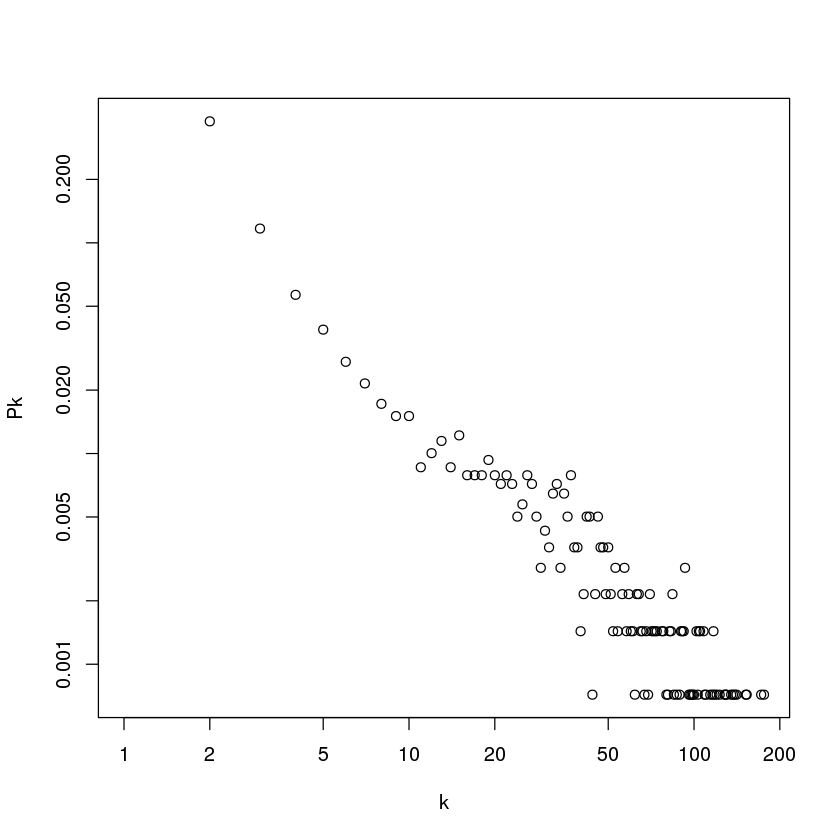

In [8]:
plot(degree.distribution(final_network), log="xy", xlab="k", ylab="Pk")

In [9]:
power.law.fit(degree(final_network))$alpha

[1] 2.745358